In [1]:
import pysr

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [2]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from pysr import PySRRegressor, TemplateExpressionSpec

In [3]:
from pysr import jl
jl.seval("""
import Pkg
Pkg.add("DataFrames")
""")
jl.seval("using DataFrames")

   Resolving package versions...
  No Changes to `~/.julia/environments/pyjuliapkg/Project.toml`
  No Changes to `~/.julia/environments/pyjuliapkg/Manifest.toml`


In [4]:
n_samples = 100

## Хороший запуск

In [5]:
X, y = make_circles(n_samples=int(n_samples), noise=0.1, factor=0.4, random_state=42)

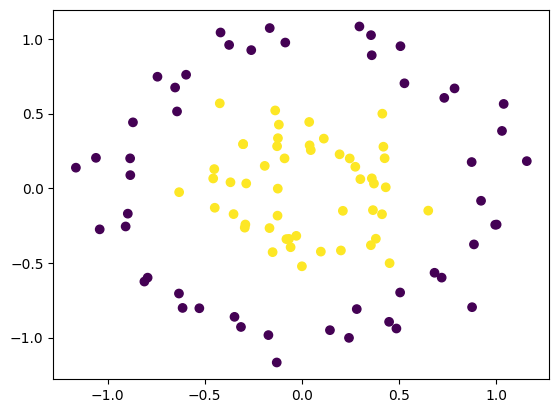

In [6]:
plt.scatter(X[:, 0], X[:, 1], c=y)

In [7]:
# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
'''
1. [Done] В лосс надо вместо MSE сделать accuracy
2. Может надо что-то сделать с complexity, чтобы выйти на rbf, а не формулу круга?
'''
model = PySRRegressor(
    niterations=100,
    populations=31,
    population_size=27,
    ncycles_per_iteration=380,
    binary_operators=["+", "*"],
    unary_operators=["exp"],
    elementwise_loss="f(x, y) = abs(x - y)",
    # complexity_of_constants=2,
    maxsize=10,
    progress=True,
    # precision=32,
    model_selection="best"
)

In [9]:
model.fit(X_train, y_train)

/home/bukkacha/.local/lib/python3.10/site-packages/pysr/sr.py:2780: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Compiling Julia backend...


[ Info: Started!
[ Info: Final population:
[ Info: Results saved to:


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           4.500e-01  1.594e+01  y = 1
5           4.500e-01  2.891e-06  y = exp(exp(x₀) * -0.0050902)
6           2.795e-01  4.761e-01  y = exp((x₁ * -3.1768) * x₁)
7           2.750e-01  1.619e-02  y = (x₁ * (x₁ * -1.1341)) + 1.025
8           2.720e-01  1.112e-02  y = exp((x₁ * -3.4038) * x₁) * 1.0788
9           1.594e-01  5.346e-01  y = exp(exp((x₁ * 39.487) * x₁) * -5.6248e-06)
───────────────────────────────────────────────────────────────────────────────────────────────────


PySRRegressor.equations_ = [
	   pick     score                                        equation      loss  \
	0        0.000000                                             1.0  0.450000   
	1        0.000003                    exp(exp(x0) * -0.0050902497)  0.449995   
	2        0.476113                     exp((x1 * -3.1768208) * x1)  0.279534   
	3        0.016191            (x1 * (x1 * -1.1341134)) + 1.0249501  0.275044   
	4        0.011117          exp((x1 * -3.4037967) * x1) * 1.078762  0.272004   
	5  >>>>  0.534616  exp(exp((x1 * 39.48651) * x1) * -5.6248246e-6)  0.159365   
	
	   complexity  
	0           1  
	1           5  
	2           6  
	3           7  
	4           8  
	5           9  
]

  - outputs/20250216_103205_cUl9t1/hall_of_fame.csv


In [10]:
model.sympy()

exp(exp(x1*39.48651*x1)*(-5.6248246e-6))

In [11]:
y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)

In [12]:
accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest accuracy: {accuracy:.4f}")


Test accuracy: 0.7500


## Очень хороший запуск

In [13]:
X, y = make_circles(n_samples=int(n_samples), noise=0.1, factor=0.4, random_state=42)

In [14]:
# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
model = PySRRegressor(
    niterations=200,
    populations=31,
    population_size=27,
    ncycles_per_iteration=380,
    binary_operators=["+", "*"],
    unary_operators=["exp"],
    elementwise_loss="f(x, y) = abs(x - y)",
    # complexity_of_constants=2,
    maxsize=15,
    progress=True,
    # precision=32,
    model_selection="best"
)

In [16]:
model.fit(X_train, y_train)

/home/bukkacha/.local/lib/python3.10/site-packages/pysr/sr.py:2780: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 9.720e+05
Progress: 5125 / 6200 total iterations (82.661%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           4.500e-01  1.594e+01  y = 1
5           4.500e-01  2.816e-06  y = exp(exp(x₀) * -0.0051337)
6           2.795e-01  4.761e-01  y = exp((x₁ * x₁) * -3.1768)
7           2.750e-01  1.619e-02  y = ((x₁ * x₁) * -1.135) + 1.0247
8           2.720e-01  1.112e-02  y = exp((x₁ * -3.4165) * x₁) * 1.079
9           1.569e-01  5.505e-01  y = exp(exp(x₁ * (x₁ * 49.061)) * -3.0393e-07)
10          1.480e-01  5.786e-02  y = exp((x₀ * -38.052) * ((x₀ * x₁) * x₁))
12          1.413e-01  2.339e-02  y = exp(x₀ * ((x₀ * x₁) * ((x₁ * -36.847) + -4.8266)))
13          1.111e-01  2.399e-01  y = exp((x₀ * (x₀ * -0.77135)) * exp((x₁ * 6.3709) * x₁))
14          1.093

[ Info: Final population:
[ Info: Results saved to:


PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                                1.0   
	1         0.000003                       exp(exp(x0) * -0.0051337024)   
	2         0.476113                        exp((x1 * x1) * -3.1768205)   
	3         0.016191               ((x1 * x1) * -1.1349763) + 1.0246994   
	4         0.011116               exp((x1 * -3.4165) * x1) * 1.0789869   
	5         0.567883    exp(exp((x1 * x1) * 64.491264) * -3.2044278e-9)   
	6         0.040439          exp((x0 * -38.052406) * ((x0 * x1) * x1))   
	7         0.023393  exp((x1 * x0) * ((-4.819459 + (x1 * -36.772892...   
	8   >>>>  0.239923  exp(x0 * (x0 * (exp(x1 * (x1 * 6.370312)) * -0...   
	9         0.016542  exp(x0 * (x0 * (-0.34212705 * exp(exp(x1 * (x1...   
	10        0.077520  exp((x0 * (exp(exp(exp(x1 * x1))) * -0.0880740...   
	
	        loss  complexity  
	0   0.450000           1  
	1   0.449995           5  
	2   0.279534           6  
	3   0.275044           7  
	4   0.272004           8  
	5   0.154151           9  
	6   0.148042          10  
	7   0.141275          12  
	8   0.111139          13  
	9   0.109316          14  
	10  0.101162          15  
]

  - outputs/20250216_103219_p70vEH/hall_of_fame.csv


In [17]:
model.sympy()

exp(x0*x0*exp(x1*x1*6.370312)*(-0.7715374))

In [18]:
y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)

In [19]:
accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest accuracy: {accuracy:.4f}")


Test accuracy: 1.0000


# Multitask

In [20]:
n_datasets = 5

In [21]:
X_all, y_all = [], []
for i in range(n_datasets):
  X, y = make_circles(n_samples=n_samples, noise=0.1, factor=0.4)
  X = np.hstack([X, i * np.ones((len(X), 1))]) 
    
  if i % 5 == 1:
    X[:, 0] += 2 * i
    X[:, 1] += 2 * i

  elif i % 5 == 2:
    X[:, 0] += 2 * i
    X[:, 1] -= 2 * i

  elif i % 5 == 3:
    X[:, 0] -= 2 * i
    X[:, 1] -= 2 * i

  elif i % 5 == 4:
    X[:, 0] -= 2 * i
    X[:, 1] += 2 * i

  if len(X_all) == 0:
    X_all = X
    y_all = y
  else:
    X_all = np.vstack([X, X_all])
    y_all = np.hstack([y, y_all])


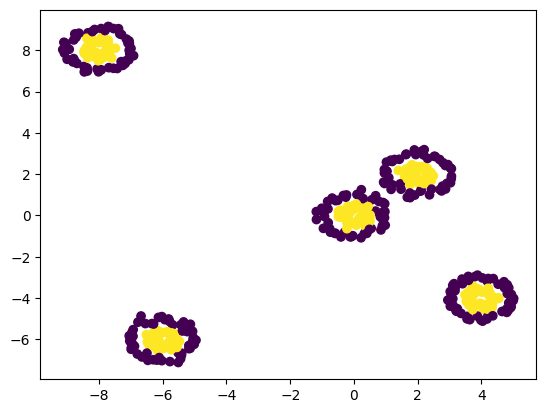

In [22]:
plt.scatter(X_all[:, 0], X_all[:, 1], c=y_all)

In [23]:
# !!! если менять, кол-во датасетов, то надо менять границы цикла
custom_loss="""
function multitask_loss(tree, dataset:: Dataset{T, L}, options)::L where {T, L}
    X_all = transpose(dataset.X)
    y_all = dataset.y
    ds_agg = hcat(X_all, y_all)
    df_agg = DataFrame(ds_agg, ["x1", "x2", "x3", "y"])

    total_loss = 0.0
    
    for dataset_id in 0:4
        df_filtered = df_agg[(df_agg.x3 .== dataset_id), Not("x3")]
        X, y = df_filtered[:, Not("y")], df_filtered[:, "y"]

        X = transpose(Matrix(X))
        prediction, flag = eval_tree_array(tree, X, options)

        if !flag
            return L(Inf)
        end 
        
        prediction = (prediction .>= 0.5)
        not_accuracy = sum(prediction .!= y) / length(prediction)
        total_loss = total_loss + not_accuracy
    end 
    
    return total_loss / 5
end
"""

In [24]:
model = PySRRegressor(
    niterations=1000,
    unary_operators=["exp"],
    binary_operators=["+", "*"],
    # maxsize=15,
    model_selection="best",
    loss_function=custom_loss
)

In [25]:
%%time
model.fit(X_all, y_all)

/home/bukkacha/.local/lib/python3.10/site-packages/pysr/sr.py:2780: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 3.370e+04
Progress: 220 / 31000 total iterations (0.710%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           5.000e-01  1.594e+01  y = 0.41734
2           4.660e-01  7.042e-02  y = exp(x₂)
3           3.880e-01  1.832e-01  y = 0.33206 + x₂
8           3.820e-01  3.117e-03  y = exp(((x₁ * -0.99154) + x₀) + x₂)
11          3.180e-01  6.112e-02  y = ((x₀ + x₁) * ((x₁ + x₀) * -4.022)) + 2.5679
12          3.160e-01  6.309e-03  y = (((x₁ + x₀) * (x₀ + x₁)) * -4.022) + exp(0.80946)
13          3.140e-01  6.349e-03  y = (((x₁ + x₀) * (x₁ + x₀)) * (x₂ + -4.022)) + 2.5679
19          3.120e-01  1.065e-03  y = ((((x₁ + x₀) + (x₀ + x₁)) * (x₁ + x₀)) * (0.602 * (x₂ ...
                                      + -4.022))) + 2.5679
23          3.100e-01  1.608e-03  y

[ Info: Final population:
[ Info: Results saved to:


PySRRegressor.equations_ = [
	    pick     score                                           equation   loss  \
	0         0.000000                                                 x2  0.370   
	1         0.005465                            x2 + (-0.08840317 * x1)  0.362   
	2         0.032877                   x2 + exp(x1 * (-1.7551409 * x1))  0.328   
	3         0.006116       0.5215281 + (((x2 + -0.08840317) * x1) * x1)  0.326   
	4         0.037504          exp((x0 + x1) * ((x0 + x1) * -1.7551409))  0.314   
	5         0.032907     x2 + exp((x1 + x0) * (-1.7551409 * (x1 + x0)))  0.294   
	6         0.018653  (x1 + 5.6260986) * (((x1 + x0) * ((x1 + x0) * ...  0.278   
	7         0.014600  ((((-2.5594597 * (x0 + x1)) * (x0 + x1)) + 1.2...  0.270   
	8         0.045462  ((((-2.5594597 * (x0 + x1)) * (x0 + x1)) + 1.2...  0.258   
	9         0.047628  ((((x1 + x0) * ((x1 + x0) * -3.544025)) + 1.73...  0.246   
	10        0.029297  (((x1 + x0) * ((x0 + x1) * -3.544025)) + 1.734...  0.232   
	11        0.040381  ((((x1 + x0) * (x0 + x1)) * ((x0 + x1) + -3.54...  0.214   
	12        0.014219  ((((x0 + x1) * ((x0 + x1) * (x0 + (x1 + -3.544...  0.208   
	13  >>>>  0.072291  ((((((x1 + x0) + -3.173992) * (x0 + x1)) * (x0...  0.180   
	14        0.011236  ((exp(x1) * -0.38873523) + exp(x0)) * ((((((x0...  0.176   
	15        0.034686  (x0 + 5.5236297) * (((((exp(x1) * -0.6794252) ...  0.170   
	
	    complexity  
	0            1  
	1            5  
	2            8  
	3            9  
	4           10  
	5           12  
	6           15  
	7           17  
	8           18  
	9           19  
	10          21  
	11          23  
	12          25  
	13          27  
	14          29  
	15          30  
]

  - outputs/20250216_103226_5P7LJ2/hall_of_fame.csv


In [26]:
model.sympy()

(x0 + 5.4666557)*((x0 + x1)*(x0 + x1)*(x0 + x1 - 3.173992) + 1.5655581)*(exp(x0) + exp(x1)*(-0.38873523))

In [32]:
X, y = make_circles(n_samples=1000, noise=0.1, factor=0.4)

# X[:, 0] += 2 * 1
# X[:, 1] += 2 * 1

# X[:, 0] += 2 * 2
# X[:, 1] -= 2 * 2

# X[:, 0] -= 2 * 3
# X[:, 1] -= 2 * 3

# X[:, 0] -= 2 * 4
# X[:, 1] += 2 * 4
X = np.hstack([X, np.ones((len(X), 1))])  # Добавляем ID датасета
y_pred = model.predict(X)
y_pred = (y_pred >= 0.5).astype(int)
accuracy = accuracy_score(y, y_pred)
print(f"Test accuracy: {accuracy:.4f}")

Test accuracy: 0.7950


In [28]:
y_pred = model.predict(X_all)
y_pred = (y_pred >= 0.5).astype(int)
accuracy = accuracy_score(y_all, y_pred)
print(f"Test accuracy: {accuracy:.4f}")

Test accuracy: 0.8200
